In [1]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from utils import *


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)


Bad key "text.kerning_factor" on line 4 in
/home/jkarabl/anaconda3/envs/emoji-gpt2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'joy, fear, anger, sadness, disgust, shame, guilt'.split(', ')

In [3]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

def tokenize(X, tokenizer, block_size=512):
    return tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=block_size)["input_ids"]

def predict_mean(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.mean(dim=0).argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_last(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits[-1].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def predict_max(X_ids, model):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_id = logits.max(0)[0].argmax().item()
        token_id = map_target_to_token_id[target_id]
        token = tokenizer.decode(token_id)
        
        preds.append(token)
    return preds

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [4]:
X, y = load_dataset(DATASETS[1])
y = decode(y)

PsychExp


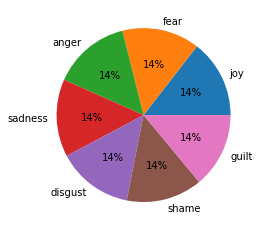

In [6]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel(None)
plt.savefig('SE0714-classes.pdf', dpi=300)

In [5]:
Xt = tokenize(X, tokenizer)

In [6]:
mean_preds = predict_mean(Xt, model)

100%|██████████| 7480/7480 [09:35<00:00, 13.01it/s]


In [7]:
last_preds = predict_last(Xt, model)

100%|██████████| 7480/7480 [09:56<00:00, 12.54it/s]


In [8]:
max_preds = predict_max(Xt, model)

100%|██████████| 7480/7480 [10:19<00:00, 12.07it/s]


In [9]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(y))
mean_cm

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
✅,1,0,0,0,0,0,0
✨,1,3,0,1,0,0,0
❤,6,0,0,2,0,0,0
🌊,4,3,0,0,0,2,0
🌞,2,0,0,0,0,0,0
🌱,1,0,0,0,0,0,0
🎂,5,0,0,0,0,0,0
🎉,1,0,0,0,0,0,0
🎶,1,3,0,1,0,0,0


In [10]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(y))
last_cm

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
✊,0,0,0,0,0,1,0
✨,5,3,0,0,0,1,0
❤,39,3,2,12,4,3,6
➡,1,0,0,0,1,0,0
🌊,3,8,1,0,0,3,0
...,...,...,...,...,...,...,...
🙃,16,48,40,14,17,35,51
🙄,1,9,62,9,68,18,10
🙏,22,7,2,7,9,4,6


In [11]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(y))
max_cm

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
☕,0,0,1,0,0,0,0
✅,21,1,7,3,0,5,1
✊,1,0,0,0,0,0,0
✨,3,1,0,1,0,0,0
❤,4,0,0,4,0,0,2
...,...,...,...,...,...,...,...
🙃,0,2,3,1,1,0,4
🙄,0,0,2,0,2,1,1
🙏,9,2,2,3,1,3,8


In [12]:
cramers_corrected_stat(mean_cm.to_numpy())

0.1620271991210835

In [13]:
cramers_corrected_stat(last_cm.to_numpy())

0.2782614044650746

In [14]:
cramers_corrected_stat(max_cm.to_numpy())

0.19819516470490542

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm.columns = CLASSES
    display(last_cm)

,joy,fear,anger,sadness,disgust,shame,guilt
row_0,,,,,,,
✊,0,0,0,0,0,1,0
✨,5,3,0,0,0,1,0
❤,39,3,2,12,4,3,6
➡,1,0,0,0,1,0,0
🌊,3,8,1,0,0,3,0
🌕,0,1,0,0,0,0,0
🌞,2,0,0,0,0,0,0
🌻,0,0,0,1,0,0,0
🍀,1,0,0,0,0,0,0


In [16]:
def predict_topk_last(X_ids, model, k=5):
    preds = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        target_ids = logits[-1].topk(k)[1].tolist()
        token_ids = [map_target_to_token_id[target_id] for target_id in target_ids]
        tokens = tokenizer.decode(token_ids)
        
        preds.append(tokens.split())
    return preds

In [17]:
last_preds_2 = predict_topk_last(Xt, model, k=2)

df = pd.DataFrame(last_preds_2)

last_cm_2 = pd.crosstab([df[col] for col in df.columns], pd.Series(y))

cramers_corrected_stat(last_cm_2.to_numpy())

 25%|██▍       | 1866/7480 [02:29<12:10,  7.69it/s]

KeyboardInterrupt: 

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    last_cm_2.columns = CLASSES
    display(last_cm_2)

In [ ]:
#Entropy
def entropy(Y):
    """
    Also known as Shanon Entropy
    Reference: https://en.wikipedia.org/wiki/Entropy_(information_theory)
    """
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

#Joint Entropy
def joint_entropy(Y,X):
    """
    H(Y;X)
    Reference: https://en.wikipedia.org/wiki/Joint_entropy
    """
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def conditional_entropy(Y, X):
    """
    conditional entropy = Joint Entropy - Entropy of X
    H(Y|X) = H(Y;X) - H(X)
    Reference: https://en.wikipedia.org/wiki/Conditional_entropy
    """
    return joint_entropy(Y, X) - entropy(X)

#Uncertainty Coefficient
def theil_u(X, Y):
    """
    Reference: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    h_X = entropy(X)
    h_XY = conditional_entropy(X, Y)
    return (h_X - h_XY) / h_X 

In [ ]:
theil_u(y, mean_preds)

In [ ]:
theil_u(y, last_preds)

In [ ]:
theil_u(y, max_preds)

In [ ]:
theil_u(y, last_preds_2)

In [ ]:
last_preds_3 = predict_topk_last(Xt, model, k=3)
theil_u(y, last_preds_3)

## Logreg

In [18]:
from sklearn.metrics import f1_score
def train_with_reg_cv(trX, trY, vaX, vaY, teX=None, teY=None, penalty='l1',
        C=2**np.arange(-8, 1).astype(np.float), seed=42, solver='liblinear', max_iter=int(1e6), metrics='score'):
    scores = []
    for i, c in enumerate(C):
        model = LogisticRegression(C=c, penalty=penalty, random_state=seed+i, solver=solver, max_iter=max_iter)
        model.fit(trX, trY)
        if metrics == 'f1':
            y_pred = model.predict(vaX)
            score = f1_score(vaY, y_pred, average='macro')
        else:
            score = model.score(vaX, vaY)
        scores.append(score)
    c = C[np.argmax(scores)]
    model = LogisticRegression(C=c, penalty=penalty, random_state=seed+len(C), solver=solver, max_iter=max_iter)
    model.fit(trX, trY)
    
    return model, c, scores

def transform_last(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits[-1].tolist())
    return probas

def transform_mean(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits.mean(0).tolist())
    return probas

def transform_max(X, model, tokenizer, args):
    X_ids = tokenize(X, tokenizer, args.block_size)
    probas = []
    for x in tqdm(X_ids):
        outputs = model(torch.tensor(x).unsqueeze(0))
        logits = outputs[0].squeeze(0)
        
        probas.append(logits.max(0)[0].tolist())
    return probas

In [19]:
Xtrans_last = transform_last(X, model, tokenizer, args)


  8%|▊         | 598/7480 [00:45<08:34, 13.38it/s]


 16%|█▌        | 1204/7480 [01:31<09:52, 10.59it/s]


 23%|██▎       | 1726/7480 [02:22<08:19, 11.51it/s]


 31%|███       | 2284/7480 [03:11<07:51, 11.03it/s]


 38%|███▊      | 2859/7480 [04:01<06:33, 11.74it/s]


 46%|████▌     | 3434/7480 [04:49<05:32, 12.17it/s]


 54%|█████▎    | 4013/7480 [05:38<04:30, 12.80it/s]


 61%|██████▏   | 4595/7480 [06:27<05:04,  9.48it/s]


 69%|██████▉   | 5161/7480 [07:18<02:30, 15.46it/s]


 77%|███████▋  | 5750/7480 [08:04<01:50, 15.61it/s]


 83%|████████▎ | 6241/7480 [08:56<01:36, 12.90it/s]


 91%|█████████▏| 6828/7480 [09:40<00:36, 17.85it/s]


 99%|█████████▉| 7395/7480 [10:23<00:11,  7.68it/s]


100%|██████████| 7480/7480 [10:35<00:00, 11.77it/s]


In [20]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=1000, random_state=42)

In [21]:
train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')

(LogisticRegression(C=0.03125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.03125,
 [0.49908100782288817,
  0.5103934867829333,
  0.5147157372864913,
  0.519669233265277,
  0.5191977815859214,
  0.51452614719557,
  0.5057256848020322,
  0.4962433776937846,
  0.4888026079341595])

In [22]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)


  3%|▎         | 204/7480 [00:25<22:02,  5.50it/s]


  9%|▉         | 702/7480 [01:17<10:20, 10.92it/s]


 17%|█▋        | 1277/7480 [02:05<08:23, 12.31it/s]


 25%|██▍       | 1849/7480 [02:55<08:13, 11.40it/s]


 33%|███▎      | 2439/7480 [03:41<07:10, 11.70it/s]


 41%|████      | 3031/7480 [04:27<05:41, 13.03it/s]


 48%|████▊     | 3603/7480 [05:13<04:56, 13.06it/s]


 56%|█████▌    | 4196/7480 [05:57<03:55, 13.97it/s]


 64%|██████▍   | 4788/7480 [06:42<03:37, 12.37it/s]


 72%|███████▏  | 5380/7480 [07:27<03:29, 10.00it/s]


 79%|███████▉  | 5945/7480 [08:15<02:22, 10.80it/s]


 87%|████████▋ | 6525/7480 [09:03<01:02, 15.19it/s]


 95%|█████████▌| 7124/7480 [09:41<00:31, 11.20it/s]


100%|██████████| 7480/7480 [10:20<00:00, 12.05it/s]


In [23]:
Xtrans_max = transform_max(X, model, tokenizer, args)


  8%|▊         | 597/7480 [00:47<10:06, 11.36it/s]


 16%|█▌        | 1199/7480 [01:32<10:56,  9.57it/s]


 23%|██▎       | 1749/7480 [02:20<06:58, 13.70it/s]


 31%|███       | 2330/7480 [03:07<11:22,  7.54it/s]


 39%|███▉      | 2918/7480 [03:53<05:09, 14.75it/s]


 47%|████▋     | 3483/7480 [04:40<04:10, 15.95it/s]


 54%|█████▍    | 4074/7480 [05:27<03:28, 16.30it/s]


 62%|██████▏   | 4666/7480 [06:12<03:53, 12.04it/s]


 70%|███████   | 5256/7480 [06:58<02:52, 12.86it/s]


 78%|███████▊  | 5839/7480 [07:44<02:55,  9.35it/s]


 86%|████████▌ | 6399/7480 [08:33<01:53,  9.52it/s]


 93%|█████████▎| 6992/7480 [09:12<00:29, 16.28it/s]


100%|██████████| 7480/7480 [09:59<00:00, 12.49it/s]


In [24]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=1000, random_state=42)

In [25]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.125,
 [0.46435185185185185,
  0.47824074074074074,
  0.49027777777777776,
  0.49583333333333335,
  0.5015432098765432,
  0.5032407407407408,
  0.5010802469135802,
  0.4959876543209877,
  0.48595679012345677])

In [26]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=1000, random_state=42)

In [27]:
model, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs')
model, C, scores

(LogisticRegression(C=0.015625, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=1000000, multi_class='auto', n_jobs=None,
                    penalty='l2', random_state=51, solver='lbfgs', tol=0.0001,
                    verbose=0, warm_start=False),
 0.015625,
 [0.42962962962962964,
  0.4368827160493827,
  0.44351851851851853,
  0.44243827160493826,
  0.43549382716049384,
  0.42824074074074076,
  0.42314814814814816,
  0.4162037037037037,
  0.4115740740740741])

## Vanilla GPT-2

In [28]:
from transformers import GPT2Model

In [29]:
model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [32]:
Xtrans_gpt2 = transform_gpt2(X, model_gpt2, tokenizer_gpt2)


  8%|▊         | 606/7480 [00:43<06:46, 16.90it/s]


 16%|█▌        | 1208/7480 [01:26<08:45, 11.93it/s]


 24%|██▍       | 1784/7480 [02:15<06:26, 14.74it/s]


 32%|███▏      | 2375/7480 [03:00<05:56, 14.31it/s]


 40%|███▉      | 2969/7480 [03:45<08:16,  9.08it/s]


 47%|████▋     | 3549/7480 [04:31<04:58, 13.19it/s]


 55%|█████▌    | 4141/7480 [05:15<03:46, 14.75it/s]


 63%|██████▎   | 4731/7480 [06:01<03:22, 13.59it/s]


 71%|███████   | 5323/7480 [06:45<01:52, 19.14it/s]


 79%|███████▉  | 5906/7480 [07:31<01:49, 14.33it/s]


 87%|████████▋ | 6475/7480 [08:19<01:29, 11.22it/s]


 94%|█████████▍| 7066/7480 [09:04<00:40, 10.28it/s]


100%|█████████▉| 7476/7480 [10:02<00:01,  3.61it/s]


100%|██████████| 7480/7480 [10:03<00:00, 12.40it/s]


In [33]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=1000, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.125, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.125,
 [0.43235257381816516,
  0.46400822077072323,
  0.49330968350127063,
  0.5184501029829918,
  0.5291181913137514,
  0.5326141737469683,
  0.5320394804045018,
  0.5277590714483618,
  0.5194825961732351])

In [34]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)


  8%|▊         | 587/7480 [00:47<10:47, 10.65it/s]


 16%|█▌        | 1184/7480 [01:31<07:01, 14.95it/s]


 23%|██▎       | 1735/7480 [02:21<07:29, 12.78it/s]


 31%|███       | 2296/7480 [03:09<08:03, 10.72it/s]


 38%|███▊      | 2875/7480 [03:57<05:27, 14.06it/s]


 46%|████▌     | 3445/7480 [04:43<05:28, 12.28it/s]


 54%|█████▍    | 4037/7480 [05:30<03:33, 16.15it/s]


 62%|██████▏   | 4630/7480 [06:14<03:50, 12.35it/s]


 70%|██████▉   | 5222/7480 [06:59<02:29, 15.06it/s]


 78%|███████▊  | 5809/7480 [07:44<02:02, 13.63it/s]


 85%|████████▌ | 6375/7480 [08:33<01:40, 10.94it/s]


 93%|█████████▎| 6973/7480 [09:14<00:27, 18.14it/s]


100%|█████████▉| 7469/7480 [10:01<00:01,  5.70it/s]


100%|██████████| 7480/7480 [10:03<00:00, 12.40it/s]


In [35]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=1000, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.0625, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0625,
 [0.4927725155316436,
  0.5071474760045519,
  0.5139152383270347,
  0.516128901747279,
  0.5180349730877679,
  0.517014046399141,
  0.5082688709976488,
  0.5016219840789076,
  0.490650944775845])